In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#problema con las propiedades leyendolo directo del excel -> por eso lo pasamos a csv
df = pd.read_csv('/Users/luisalawson/Downloads/Sample Data/epl.csv', delimiter=';')

In [4]:
df_prop = pd.DataFrame({
    'column_name': df.columns,
    'data_type': df.dtypes.values
})

In [5]:
df_vals = pd.DataFrame({
    'column_name': df.columns,
    'column_values': [set(df[col].tolist()) for col in df.columns],
    'unique_value_count': [len(set(df[col].tolist())) for col in df.columns]
})

In [7]:
df_vals

,column_name,column_values,unique_value_count
0,season_id,{2012},1
1,match_id,"{442368, 442369, 442370, 442371, 442372, 44237...",380
2,home_team_id,"{1, 3, 4, 6, 7, 8, 11, 14, 20, 21, 35, 43, 45,...",20
3,home_team_name,"{Southampton, Tottenham Hotspur, Newcastle Uni...",20
4,away_team_id,"{1, 3, 4, 6, 7, 8, 11, 14, 20, 21, 35, 43, 45,...",20
5,away_team_name,"{Southampton, Tottenham Hotspur, Newcastle Uni...",20
6,id,"{543162368, 1138753537, 123731970, 920649732, ...",648883
7,event_id,"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1160
8,date,"{20Apr2013, 23Sep2012, 21Oct2012, 11Dec2012, 2...",107
9,time,"{2:24:58 PM, 5:13:11 PM, 6:43:33 PM, 4:44:59 P...",31752


In [30]:
player_stats = []
player_names = df['playerName'].unique()

In [32]:
for player_name in player_names:
    if player_name == 'nan' or player_name == 'NaN':
        pass
    else:
        # Filter the DataFrame for the current player
        player_df = df[df['playerName'] == player_name]
        
        if not player_df.empty:
            # Safely retrieve team_id and playerPosition, using .iloc for robust indexing
            team_id = player_df['team_id'].iloc[0] if not player_df['team_id'].empty else None
            position = player_df['playerPosition'].iloc[0] if not player_df['playerPosition'].empty else None
            
            stats = {
                'player_name': player_name,
                'team_id': team_id,
                'position': position,
                'Interceptions': player_df[player_df['description'] == 'Interception'].shape[0],
                'success_interceptions': player_df[(player_df['description'] == 'Interception') & (player_df['outcome'] == 1)].shape[0],
                'Tackle': player_df[player_df['description'] == 'Tackle'].shape[0],
                'success_tackles': player_df[(player_df['description'] == 'Tackle') & (player_df['outcome'] == 1)].shape[0],
                'Clearance': player_df[player_df['description'] == 'Clearance'].shape[0],
                'success_clearance': player_df[(player_df['description'] == 'Clearance') & (player_df['outcome'] == 1)].shape[0],
                'Blocked Pass': player_df[player_df['description'] == 'Blocked pass'].shape[0],
                'success_blockedPass': player_df[(player_df['description'] == 'Blocked pass') & (player_df['outcome'] == 1)].shape[0],
                'Ball Recovery': player_df[player_df['description'] == 'Ball recovery'].shape[0],
                'success_ballRecovery': player_df[(player_df['description'] == 'Ball recovery') & (player_df['outcome'] == 1)].shape[0],
            }
            
            player_stats.append(stats)

In [33]:
df_players = pd.DataFrame(player_stats)

In [34]:
df_players

,player_name,team_id,position,Interceptions,success_interceptions,Tackle,success_tackles,Clearance,success_clearance,Blocked Pass,success_blockedPass,Ball Recovery,success_ballRecovery
0,"Podolski, Lukas",3,Striker,15,15,32,25,23,10,0,0,68,68
1,"Cazorla, Santiago",3,Midfielder,69,69,71,55,18,8,0,0,247,247
2,"Vermaelen, Thomas",3,Defender,47,47,43,35,139,85,0,0,89,89
3,"Walcott, Theo",3,Midfielder,11,11,16,15,5,0,0,0,89,89
4,"Sessegnon, Stephane",56,Midfielder,11,11,20,17,7,3,0,0,97,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,"Ibe, Jordon",14,Midfielder,1,1,1,1,0,0,0,0,8,8
519,"Knott, Billy",56,Substitute,0,0,0,0,0,0,0,0,2,2
520,"Mitchell, Adam",56,Substitute,0,0,0,0,0,0,0,0,0,0
521,"Fyvie, Fraser",111,Substitute,1,1,1,1,0,0,0,0,2,2


In [35]:
df_sorted = df_players.sort_values(by='success_ballRecovery', ascending=False)

In [40]:
position_sums = df_sorted.groupby('position')['success_ballRecovery'].sum()
defenders_ballrecovery = position_sums.get('Defender', 0)
midfielders_ballrecovery = position_sums.get('Midfielder', 0)
strikers_ballrecovery = position_sums.get('Striker', 0)

In [41]:
print(f"Total successful ball recoveries by Defenders: {defenders_ballrecovery}")
print(f"Total successful ball recoveries by Midfielders: {midfielders_ballrecovery}")
print(f"Total successful ball recoveries by Strikers: {strikers_ballrecovery}")

Total successful ball recoveries by Defenders: 9890
Total successful ball recoveries by Midfielders: 12436
Total successful ball recoveries by Strikers: 2645


In [43]:
position_sums = df_sorted.groupby('position')['success_interceptions'].sum()
defenders_interceptions = position_sums.get('Defender', 0)
midfielders_interceptions = position_sums.get('Midfielder', 0)
strikers_interceptions = position_sums.get('Striker', 0)

In [44]:
print(f"Total successful interceptions by Defenders: {defenders_interceptions}")
print(f"Total successful interceptions by Midfielders: {midfielders_interceptions}")
print(f"Total successful interceptions by Strikers: {strikers_interceptions}")

Total successful interceptions by Defenders: 4669
Total successful interceptions by Midfielders: 3693
Total successful interceptions by Strikers: 562


In [45]:
position_sums = df_sorted.groupby('position')['success_clearance'].sum()
defenders_clearance = position_sums.get('Defender', 0)
midfielders_clearance = position_sums.get('Midfielder', 0)
strikers_clearance = position_sums.get('Striker', 0)

In [51]:
print(f"Total successful clearances by Defenders: {defenders_clearance}")
print(f"Total successful clearances by Midfielders: {midfielders_clearance}")
print(f"Total successful clearances by Strikers: {strikers_clearance}")

Total successful clearances by Defenders: 9532
Total successful clearances by Midfielders: 1821
Total successful clearances by Strikers: 334


In [53]:
position_sums = df_sorted.groupby('position')['success_tackles'].sum()
defenders_tackle = position_sums.get('Defender', 0)
midfielders_tackle = position_sums.get('Midfielder', 0)
strikers_tackle = position_sums.get('Striker', 0)

In [54]:
print(f"Total successful tackles by Defenders: {defenders_tackle}")
print(f"Total successful tackles by Midfielders: {midfielders_tackle}")
print(f"Total successful tackles by Strikers: {strikers_tackle}")

Total successful tackles by Defenders: 3687
Total successful tackles by Midfielders: 3784
Total successful tackles by Strikers: 703


In [47]:
import matplotlib.pyplot as plt
import numpy as np

In [55]:
positions = ['Defenders', 'Midfielders', 'Strikers']

ball_recovery = [defenders_ballrecovery, midfielders_ballrecovery, strikers_ballrecovery]
interceptions = [defenders_interceptions, midfielders_interceptions, strikers_interceptions]
clearance = [defenders_clearance, midfielders_clearance, strikers_clearance]
tackles = [defenders_tackle, midfielders_tackle, strikers_tackle]

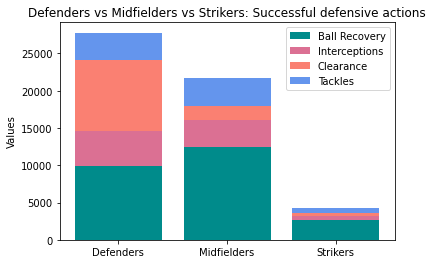

In [56]:
fig, ax = plt.subplots()

ax.bar(positions, ball_recovery, label='Ball Recovery', color='darkcyan')
ax.bar(positions, interceptions, bottom=ball_recovery, label='Interceptions', color='palevioletred')
ax.bar(positions, clearance, bottom=np.array(ball_recovery) + np.array(interceptions), label='Clearance', color='salmon')
ax.bar(positions, tackles, bottom=np.array(ball_recovery) + np.array(interceptions) + np.array(clearance), label='Tackles', color='cornflowerblue')

ax.set_ylabel('Values')
ax.set_title('Defenders vs Midfielders vs Strikers: Successful defensive actions')
ax.legend()

# Display the plot
plt.show()

In [5]:
def get_team_id_matches(team, df):
    idvalues = df[(df['home_team_name'] == team) | (df['away_team_name'] == team)]['match_id'].unique()
    return idvalues

In [7]:
def get_lineups(team_id, df):
    df_team = df[df['team_id'] == team_id] 
    lineups = set()
    for index, row in df_team.iterrows():
        lineups.add(row['playerName'])
        
    return lineups

In [6]:
def build_team_info(df):
    team_info = {}

    # to organize the info for a better access

    # we will use the team name as keys
    team_names = set(df['home_team_name']).union(df['away_team_name'])
    team_ids = set(df['home_team_id']).union(df['away_team_id'])

    # fill our dict
    for team_name in team_names:
        
        # gather team id data
        if (df['home_team_name'] == team_name).any():
            team_ids_for_name = df[df['home_team_name'] == team_name]['home_team_id'].unique()
        elif (df['away_team_name'] == team_name).any():
            team_ids_for_name = df[df['away_team_name'] == team_name]['away_team_id'].unique()
        
        team_id = team_ids_for_name[0] if len(team_ids_for_name) > 0 else None
        
        team_info[team_name] = {
            'team_id': team_id,
            'matches': get_team_id_matches(team_name, df),
            'lineups': get_lineups(team_id, df)
        }

    return team_info

In [100]:
def calculate_plays(df, home_team, away_team):
   
    home_plays = 0
    away_plays = 0
    

    home_current = False
    away_current = False

    for index, row in df.iterrows():
        
        if index > 4:  # the match starts always on row 5
            
            team_play = row['team_id']
            situation = row['description']
            x_value = float(row['x'].replace(',','.'))
            y_value = float(row['y'].replace(',','.'))
            
            
            if situation == 'End':
                return home_plays, away_plays
            
            if team_play == home_team and not home_current:
                home_plays +=1
                home_current = True
                away_current = False
            
            elif team_play== away_team and not away_current:
                away_plays +=1
                away_current = True
                home_current = False

            elif y_value< 0 or y_value >100 or x_value > 100 or x_value <0:
                home_current = False
                away_current = False
            
            else:
                pass

        
    return home_plays, away_plays

In [101]:
def calculate_dangerous_plays(df, home_team_id, away_team_id):
    home_team_dangerous_plays = 0
    away_team_dangerous_plays = 0

    home_current = False
    away_current = False

    # Define dangerous zones
    home_danger_zones = {
        1: (65, 100),
        2: (0, 35)
    }
    away_danger_zones = {
        1: (0, 35),
        2: (65, 100)
    }

    for index, row in df.iterrows():
        team_play = row['team_id']
        x_value = float(row['x'].replace(',','.'))
        period = row['period_id']

        # Get dangerous zones based on period
        home_danger_zone = home_danger_zones.get(period, (0, 0))
        away_danger_zone = away_danger_zones.get(period, (0, 0))

        # Check if the ball has left the dangerous zone
        if home_current and not (home_danger_zone[0] <= x_value <= home_danger_zone[1]):
            home_current = False
        if away_current and not (away_danger_zone[0] <= x_value <= away_danger_zone[1]):
            away_current = False

        # Handle home team
        if team_play == home_team_id:
            if not home_current and (home_danger_zone[0] <= x_value <= home_danger_zone[1]):
                home_team_dangerous_plays += 1
                home_current = True
                away_current = False

        # Handle away team
        if team_play == away_team_id:
            if not away_current and (away_danger_zone[0] <= x_value <= away_danger_zone[1]):
               
                away_team_dangerous_plays += 1
                away_current = True
                home_current = False

       

    return away_team_dangerous_plays, home_team_dangerous_plays


In [102]:
def game_outcome(df):
    match_id_values = df['match_id'].unique()
    match_outcomes = []
    shot_categories = ['Attempt Saved', 'Miss', 'Goal', 'Out']
    defensive_events_1 = ['Tackle', 'Interception', 'Clearance', 'Blocked Pass', 'Ball Recovery'] 
    defensive_events_0 = ['Tackle', 'Failed to Block'] 
    
    for match in match_id_values:
        
        df_match = df[df['match_id'] == match]
        
        # should be the same teams on every row
        home_team = df_match['home_team_name'].iloc[0]
        away_team = df_match['away_team_name'].iloc[0]

        # useful to know which player scored (to add goal to that team) 
        home_team_id = df_match['home_team_id'].iloc[0]
        away_team_id = df_match['away_team_id'].iloc[0]

        # same as home_team
        date = df_match['date'].iloc[0]
        
        # goal calculation
        home_score = df_match[(df_match['team_id'] == home_team_id) & (df_match['description'] == "Goal")]['outcome'].sum()
        away_score = df_match[(df_match['team_id'] == away_team_id) & (df_match['description'] == "Goal")]['outcome'].sum()

        #shot calculation
        # attempt saved in description 
        # miss
        # goal (?
        # out(?
        home_shots = ((df_match['team_id'] == home_team_id) & (df_match['description'].isin(shot_categories)) & (df_match['outcome'] == 1)).sum()
        away_shots = ((df_match['team_id'] == away_team_id) & (df_match['description'].isin(shot_categories) & (df_match['outcome'] == 1))).sum()

        #possession calculation
        #home_possession = (df_match['team_id'] == home_team_id).sum()
        #away_possession = (df_match['team_id'] == away_team_id).sum()

        home_possession, away_possession = calculate_plays(df_match, home_team_id, away_team_id)

        # Defense calculation

        total_defenses_home = ((df_match['team_id'] == home_team_id) & ((df_match['description'].isin(defensive_events_0)) | (df_match['description'].isin(defensive_events_1)))).sum()
        total_defenses_away = ((df_match['team_id'] == away_team_id) & ((df_match['description'].isin(defensive_events_0)) | (df_match['description'].isin(defensive_events_1)))).sum()

        succesfull_defense_home = ((df_match['team_id'] == home_team_id) & ( (  (df_match['description'].isin(defensive_events_0)) & (df_match['outcome'] == 0) ) | (  (df_match['description'].isin(defensive_events_1)) & (df_match['outcome'] == 1) ))).sum()
        succesfull_defense_away = ((df_match['team_id'] == away_team_id) & ( (  (df_match['description'].isin(defensive_events_0)) & (df_match['outcome'] == 0) ) | (  (df_match['description'].isin(defensive_events_1)) & (df_match['outcome'] == 1) ))).sum()

        #PSL calculation
        home_PSL = home_shots/home_possession
        away_PSL = away_shots/away_possession

        #PSL diff
        home_PSL_dif = home_PSL - away_PSL
        away_PSL_dif = away_PSL - home_PSL

        # Calculo DC
        dc_home = succesfull_defense_home / total_defenses_home
        dc_away = succesfull_defense_away / total_defenses_away

        dc_dif_home = dc_home- dc_away
        dc_dif_away = dc_away- dc_home

        dc_accurate = 0
    
        if(home_score > away_score and dc_home > dc_away):
            dc_accurate += 1
        elif(home_score < away_score and dc_home < dc_away):
            dc_accurate += 1
        elif(home_score == away_score and abs(dc_dif_home) < 0.1):
            dc_accurate += 1
        else:
            dc_accurate += 0

        #calculate RPDA

        home_dangerous_possession, away_dangerous_possession = calculate_dangerous_plays(df_match,home_team_id,away_team_id)

        home_RPDA = home_dangerous_possession
        away_RPDA = away_dangerous_possession

        # recover all match
        match_outcomes.append({
            'match_id': match,
            'date': date,
            'home_team': home_team,
            'away_team': away_team,
            'home_score': home_score,
            'away_score': away_score,
            'home_shots':home_shots,
            'away_shots':away_shots,
            'home_possesion': home_possession,
            'away_possession': away_possession,
            'home_PSL':"{:.4f}".format(home_PSL),
            'away_PSL': "{:.4f}".format(away_PSL),
            'home_PSL_dif': "{:.4f}".format(home_PSL_dif),
            'away_PSL_dif': "{:.4f}".format(away_PSL_dif),
            'dc_home': "{:.4f}".format(dc_home),
            'dc_away': "{:.4f}".format(dc_away),
            'dc_dif_home': "{:.4f}".format(dc_dif_home),
            'dc_dif_away': "{:.4f}".format(dc_dif_away),
            'dc_accuracy': dc_accurate,
            'rpda_home':home_RPDA,
            'rpda_away':away_RPDA
        })
    
    
    outcome_df = pd.DataFrame(match_outcomes)
    
    return outcome_df  

In [103]:
match_results_df = game_outcome(df)
# not accurate --> we found og (own goals) are not distinguished from sg (successful goals)
# eg. 19May2013	Wigan Athletic- Aston Villa	--> 1- 3 was actually 2-2 for an aston villa player scored an og in the minute 45

match_results_df

,match_id,date,home_team,away_team,home_score,away_score,home_shots,away_shots,home_possesion,away_possession,...,away_PSL,home_PSL_dif,away_PSL_dif,dc_home,dc_away,dc_dif_home,dc_dif_away,dc_accuracy,rpda_home,rpda_away
0,441999,18Aug2012,Arsenal,Sunderland,0,0,46,36,150,149,...,0.2416,0.0651,-0.0651,0.9778,0.8621,0.1157,-0.1157,0,149,159
1,442000,20Aug2012,Everton,Manchester United,1,0,47,46,164,162,...,0.2840,0.0026,-0.0026,0.7564,0.7719,-0.0155,0.0155,0,189,172
2,442001,18Aug2012,Fulham,Norwich City,5,0,42,32,131,132,...,0.2424,0.0782,-0.0782,0.7273,0.7963,-0.0690,0.0690,0,137,152
3,442002,19Aug2012,Manchester City,Southampton,3,2,52,36,127,127,...,0.2835,0.1260,-0.1260,0.8113,0.7600,0.0513,-0.0513,1,134,164
4,442003,18Aug2012,Newcastle United,Tottenham Hotspur,2,1,42,36,167,165,...,0.2182,0.0333,-0.0333,0.7097,0.6825,0.0271,-0.0271,1,139,132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,442374,19May2013,Swansea City,Fulham,0,3,49,30,129,131,...,0.2290,0.1508,-0.1508,0.9796,0.7037,0.2759,-0.2759,0,117,98
376,442375,19May2013,Tottenham Hotspur,Sunderland,1,0,71,47,167,166,...,0.2831,0.1420,-0.1420,0.8529,0.7375,0.1154,-0.1154,1,142,145
377,442376,19May2013,West Bromwich Albion,Manchester United,6,4,43,46,118,117,...,0.3932,-0.0288,0.0288,0.8049,0.8627,-0.0579,0.0579,0,152,118
378,442377,19May2013,West Ham United,Reading,4,2,63,52,153,154,...,0.3377,0.0741,-0.0741,0.8182,0.8727,-0.0545,0.0545,0,153,162


In [99]:
excel_file_path = '/Users/luisalawson/Downloads/match_results.xlsx'  

match_results_df.to_excel(excel_file_path, index=False)

print(f"DataFrame saved to {excel_file_path}")

DataFrame saved to /Users/luisalawson/Downloads/match_results.xlsx


In [22]:
match_results_df['dc_accuracy'].sum()

np.int64(196)

In [23]:
match_results_df['dc_away'].min()

'0.5435'

In [15]:
teams1 = df['home_team_name'].unique()
teams2 = df['away_team_name'].unique()

teams = set(teams2) | set(teams2)

In [16]:
# Calculate averages
home_dc_avg = match_results_df.groupby(['home_team', 'away_team'])['dc_home'].mean().reset_index()
away_dc_avg = match_results_df.groupby(['away_team', 'home_team'])['dc_away'].mean().reset_index()

In [17]:
# Initialize dictionary to store average opponent dc
average_opponents_dc = {}

# Get unique teams
teams = match_results_df['home_team'].unique()

# Calculate average opponents' mean_dc for each team
for team in teams:
    # Find opponents for this team
    opponents = home_dc_avg[home_dc_avg['home_team'] == team]['away_team'].tolist()
    
    # Filter away_dc_avg for opponents and calculate mean dc
    opponents_dc = away_dc_avg[away_dc_avg['away_team'].isin(opponents)]['dc_away']
    
    # Store average opponent dc
    average_opponents_dc[team] = opponents_dc.mean()

In [18]:
average_opponents_dc

{'Arsenal': np.float64(0.7796827989775985),
 'Everton': np.float64(0.7815826108653073),
 'Fulham': np.float64(0.7808680679415381),
 'Manchester City': np.float64(0.7808908106335143),
 'Newcastle United': np.float64(0.7830521427995245),
 'Queens Park Rangers': np.float64(0.7795731005328362),
 'Reading': np.float64(0.7810886270361524),
 'West Bromwich Albion': np.float64(0.7808601388564708),
 'West Ham United': np.float64(0.7822008884531649),
 'Wigan Athletic': np.float64(0.7786241977578361),
 'Aston Villa': np.float64(0.7815822374605327),
 'Chelsea': np.float64(0.778915121774588),
 'Liverpool': np.float64(0.7799492337439509),
 'Manchester United': np.float64(0.7801864969322005),
 'Norwich City': np.float64(0.78038803600119),
 'Southampton': np.float64(0.7788788415606799),
 'Stoke City': np.float64(0.7791849455256461),
 'Sunderland': np.float64(0.7812029817538991),
 'Swansea City': np.float64(0.7823200790202749),
 'Tottenham Hotspur': np.float64(0.7827620798029945)}

In [30]:
match_results_df['dc_dif_home'].min()

'-0.0002'

In [31]:
match_results_df['dc_dif_home'].max()

'0.3000'

In [26]:
match_results_df['dc_dif']

TypeError: unsupported format string passed to Series.__format__

In [ ]:
for team in teams:
    
    home_matches = home_dc_avg[home_dc_avg['home_team'] == team]
    away_matches = away_dc_avg[away_dc_avg['away_team'] == team]

    plt.figure(figsize=(10, 5))

    # Plot home_dc
    plt.plot(home_matches['away_team'], home_matches['dc_home'], color='palevioletred', marker='o', label='home_dc')

    # Plot away_dc
    plt.plot(away_matches['home_team'], away_matches['dc_away'], color='darkcyan', marker='o', label='away_dc')
    
    
    plt.title(f'{team} DC Values')
    plt.xlabel('Opponent Team')
    plt.ylabel('DC Value')
    plt.legend()
    plt.xticks(range(len(home_matches)), home_matches['away_team'], rotation=90)
    plt.tight_layout()
    plt.ylim(0.5, 1.0)

    
    #plt.show()  # 
    #  
    #plt.savefig(f'{team}_dc_values.png')